# Loading the libraries

In [143]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans

# Loading the dataset

In [131]:
data = pd.read_csv('EmployeeSurvey.csv')

# Intitial exploration of the data

In [132]:
print("First 5 rows⬇️:\n")
print(data.head())
print("\nLast 5 rows⬇️:\n")
print(data.tail())
print("\nGeneral information about the dataset⬇️:\n")
print(data.info())
print(f"Numbers of rows and columns in the dataset: {data.shape}")
print(f"\nData counted: \n{data.count()}\n")
print(f"\nRows with at least one null value: {data.isnull().any(axis=1).sum()}")


First 5 rows⬇️:

   Emp ID  satisfaction_level  last_evaluation  number_project  \
0     1.0                0.38             0.53             2.0   
1     2.0                0.80             0.86             5.0   
2     3.0                0.11             0.88             7.0   
3     4.0                0.72             0.87             5.0   
4     5.0                0.37             0.52             2.0   

   average_montly_hours  time_spend_company  Work_accident  \
0                 157.0                 3.0            0.0   
1                 262.0                 6.0            0.0   
2                 272.0                 4.0            0.0   
3                 223.0                 5.0            0.0   
4                 159.0                 3.0            0.0   

   promotion_last_5years   dept  salary  
0                    0.0  sales     low  
1                    0.0  sales  medium  
2                    0.0  sales  medium  
3                    0.0  sales     low  
4  

# Improving the quality of data

###### Renaming columns to make it more clear which type of data do they store

In [133]:
column_mapping = {
    'Emp ID': 'employee ID',
    'satisfaction_level': 'satisfaction level',
    'last_evaluation': 'evaluation score',
    'number_project': 'projects engaged in',
    'average_montly_hours': 'monthly hours',
    'time_spend_company': 'years at company',
    'Work_accident': 'work accidents',
    'promotion_last_5years': 'promoted last 5 years',
    'dept': 'department',
    'salary': 'salary level'
}

data.rename(columns=column_mapping, inplace=True)

###### First, I will drop the ‘Emp ID’ column as it is not meaningful for predictions and is not an ideal index, given that it starts from 1 instead of 0. Also for my task I'm not interested to keep track of personalities, but rather just the data of each employee.

In [134]:
data.drop("employee ID", axis=1, inplace=True)

###### Since there are not much null values in comparison to the general size of the dataset - the best solution for the precision of the future predictions will be simply from them.

In [135]:
data.dropna(inplace=True)
print(f"\nRows with at least one null value after dropping nulls: {data.isnull().any(axis=1).sum()}")


Rows with at least one null value after dropping nulls: 0


### I am focusing on exploring the sales department, as it is one of the largest in the dataset. Additionally, career patterns often vary significantly across different professions, which could lead to reduced prediction accuracy if analyzed together.

In [136]:
is_sales_department = data['department'] == 'sales'
data = data.loc[is_sales_department]
data.drop("department", axis=1, inplace=True)
# Getting rid of the "department" column, since we will explore just sales department

### Separating DataFrames for Target Variables and Features

In [137]:
target_var = 'satisfaction level'
Y = data[target_var].copy()
X = data.copy().drop([target_var], axis=1)

### Transforming the categorical column "salary" into numerical one

In [139]:
salary_mapping = {'low': 1, 'medium': 2, 'high': 3}
X['salary level'] = X['salary level'].map(salary_mapping)

##### Let’s explore the data more closely by plotting it. After normalizing, we can analyze the dynamics of how features influence the target variable, rather than focusing on their actual values.

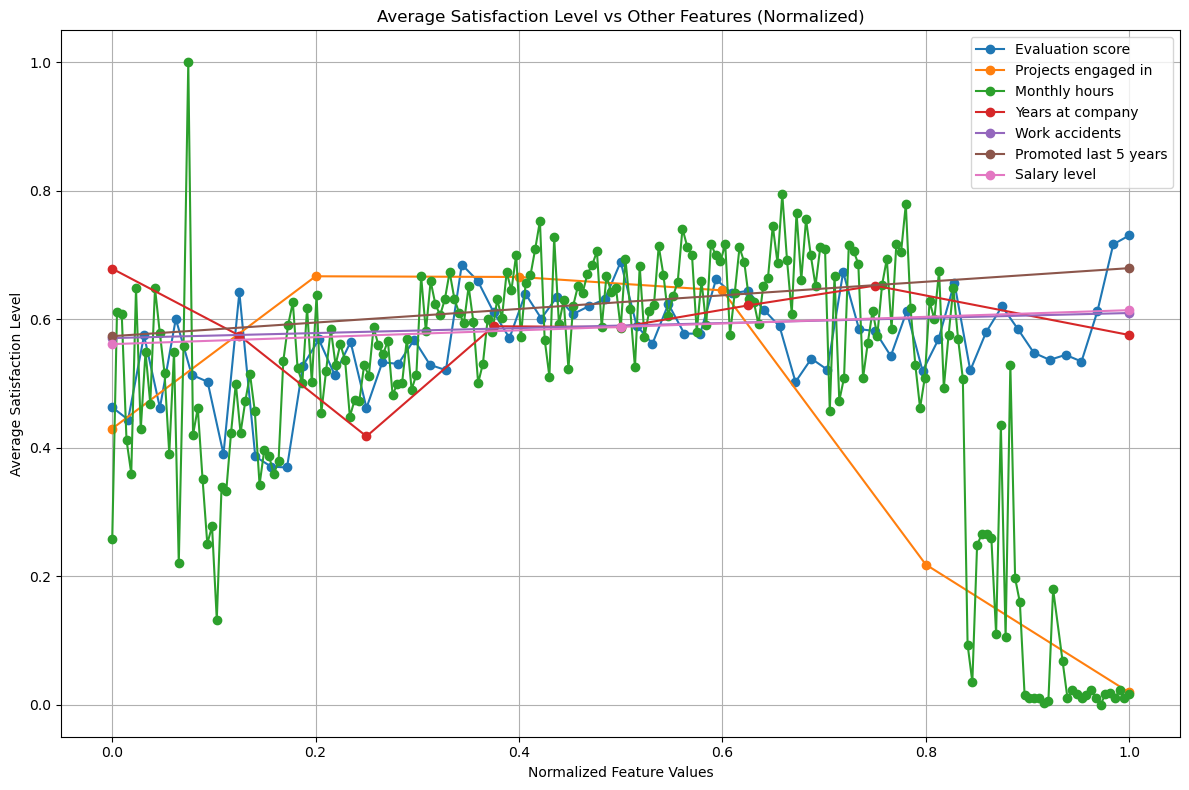

In [142]:

scaler = MinMaxScaler()
data_transformed = pd.merge(Y, X, left_index=True, right_index=True)
data_normalized = pd.DataFrame(scaler.fit_transform(data_transformed), columns=data_transformed.columns)

plt.figure(figsize=(12, 8))

for column in data_normalized.columns:
    if column != target_var:
        average_satisfaction = data_normalized.groupby(column)[target_var].mean()
        plt.plot(average_satisfaction.index, average_satisfaction.values, marker='o', label=column.capitalize())

plt.title("Average Satisfaction Level vs Other Features Impacting It (Normalized)")
plt.xlabel("Normalized Feature Values")
plt.ylabel("Average Satisfaction Level")
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()



## Analyzing the Data and Addressing Key Questions:


### 1) How can we be sure of the Dataset’s quality? Could the research it’s based on be poor?

###### The dataset taken from the "Employee Satisfaction Survey Data" posted on "https://www.kaggle.com/datasets/redpen12/employees-satisfaction-analysis", Kaggle is a reputable platform known for hosting a wide range of datasets used by data scientists and researchers worldwide. This particular dataset has the heighest rating possible (10.0) regarding all the evaluation factors: Completeness, Credibility and Compatibility, while having a significant number of views and downloads.
###### The dataset includes various features relevant to employee satisfaction analysis, such as:
###### - Employee ID: Unique identifier for each employee.
###### - Department: The department where the employee works.
###### - Satisfaction Level: A numerical value representing the employee’s satisfaction.
###### - Last Evaluation: The score from the employee’s most recent evaluation.
###### - Number of Projects: The number of projects the employee is involved in.
###### - Average Monthly Hours: The average number of hours the employee works per month.
###### - Time Spent at Company: The number of years the employee has been with the company.
###### - Work Accident: Indicator of whether the employee has had a work accident.
###### - Promotion in Last 5 Years: Indicator of whether the employee was promoted in the last five years.
###### - Salary: The salary level of the employee (e.g., low, medium, high).
###### These factors suggest that other data analitics, ML professionals and others have found it useful in their works.

### 2) Is the relationship between the data linear?
###### In most cases, the relationship is not linear. Instead, it often resembles a U-shaped or inverted U-shaped pattern between the features and the target variable. While some relationships are completely linear (promotion last 5 years, salary, work accident), they tend to be the least influential on the target value. This suggests that a linear model may not be the best choice for making predictions in this scenario.

###### Furthermore, there is no clear exponential pattern in the data. Instead, certain ranges of feature values correspond to increases or decreases in the target variable. This is particularly evident in features like average monthly hours or last evaluation.

###### Based on this exploration, it becomes clear that while the problem might initially appear suitable for regression, effectively capturing these complex relationships would likely require advanced algorithms such as Gradient Boosted Trees (e.g., XGBoost, LightGBM). However, these algorithms were not covered in this class.

###### On the other hand, the dataset offers another opportunity: most of the numerical features are decimals ranging from 0 to 1. This makes it straightforward to transform the data into a classification problem, which may be better suited to handle these challenging U-shaped and uneven relationships. For instance, values below 0.2 could be labeled as “very low,” values below 0.4 as “low,” values below 0.6 as “medium,” and so on.

### 3) Which features looks the most important in influencing the target variable?

###### 1.	Time Spent at the Company: This is one of the most significant predictors of employee satisfaction.
###### 2.	Number of Projects: The number of projects an employee is engaged in plays a critical role in shaping their satisfaction level.
###### 3.	Average Monthly Hours: This feature also appears to have a strong influence on employee satisfaction.
###### 4.	Last Evaluation: While slightly less impactful compared to other factors, the last evaluation still holds importance in predicting satisfaction levels.

### 4) What is the dynamics of this features' influence on the target variable? Does it makes sense, or it rather looks that there is some mistake in the data visualization?

#### 1. Time Spent at the Company

1.1 Initial Excitement

	•	At the start of their career, employees tend to be highly satisfied. Passing both technical and soft skills interviews is challenging, and securing the job often feels like a significant accomplishment.
	•	Many new hires may have received multiple offers but chose their current role because it seemed like the best fit for them.

1.2 The Stress of the First Year

	•	The first year is often stressful. Employees are still adapting to the company, learning its work patterns, and trying to understand its specific workflows.
	•	This adjustment period can temporarily lower satisfaction levels.

1.3 Gaining Stability and Satisfaction

	•	By the end of the first year, employees typically become more comfortable with the company’s work environment and processes.
	•	This familiarity often leads to improved performance, making them more valuable to the company compared to new hires. They may receive promotions or recognition, which boosts their satisfaction.

1.4 Stagnation Around Three Years

	•	After approximately three years, employees often experience stagnation. Promotions become less frequent, and their skills may feel overly specialized or company-specific, making them less relevant in the broader job market.
	•	This realization can lead to stress as employees question whether they possess the marketable skills needed to succeed elsewhere. Concerns about job security and future opportunities may arise.

1.5 Considering a Change

	•	These concerns often prompt employees to consider switching companies—not necessarily to change their career path, but to ensure their skills remain relevant and their growth continues.

#### 2. Number of Projects

###### For those with experience in their tech company careers, it’s well understood that companies may hire employees for specific projects (project-only contracts) or as valuable general specialists.
	•	Too Few Projects:
###### Employees with a minimal number of projects often question their importance to the company and worry about the stability of their position. This lack of engagement can create feelings of insecurity and reduced job satisfaction.
	•	Optimal Number of Projects:
###### When employees are engaged in a reasonable number of projects, they feel more confident in their value to the company. This balance fosters a sense of stability and reduces concerns about their replaceability.
	•	Excessive Number of Projects:
###### Being involved in too many projects can negatively impact focus, disrupt work-life balance, and create stress. It may also make employees feel like they are working in a small outsourcing company that prioritizes rapid project completion over quality. This perception can be particularly frustrating if it doesn’t align with the company’s actual values.

#### 3. Average Monthly Hours

###### The average monthly hours an employee works can influence their satisfaction level in a way similar to the number of projects they are engaged in. The Dunning-Kruger effect may also apply here—employees tend to value their work more as they contribute more, but only within reasonable limits.
	•	Too Few Hours:
###### Employees working too few hours may feel disconnected from the company, leading to a lack of engagement. This could make them feel less integrated into the company culture and less aware of others’ contributions. Furthermore, for employees who spend significant time commuting, the time invested may not feel justified. Insufficient working hours may also hinder their ability to adapt to new work contexts or fully grasp their role.
	•	Optimal Hours:
###### Working a balanced and reasonable number of hours allows employees to maintain a healthy level of engagement. This balance helps them feel productive and valued without overextending themselves, contributing positively to their satisfaction.
	•	Excessive Hours:
###### When employees work excessive hours, they risk burnout, which can lead to decreased motivation and job satisfaction. This overwork can harm their work-life balance and overall well-being, ultimately diminishing their performance and satisfaction.

#### 4. Evaluation In Last 5 Years and Employee's Satisfaction

###### While evaluation scores fluctuate over time, a clear trend emerges when focusing on the highest and lowest values of job evaluations over the last five years:
	•	Lowest Evaluation Scores:
###### Employees with the lowest evaluation scores tend to exhibit the lowest levels of job satisfaction. This may stem from a lack of recognition or attention from the company, leaving employees feeling undervalued and disconnected from their work.
	•	Highest Evaluation Scores:
###### On the other hand, employees with the highest evaluation scores generally report the highest levels of job satisfaction. Regular and high evaluations provide employees with a sense of acknowledgment and validation. They feel that their efforts are being noticed and appreciated, which motivates them to work harder and remain committed to the organization.
	•	Benefits to the Company:
###### By tracking employee success, organizations can identify and reward high-performing individuals, fostering a culture of accountability and motivation.

#### 5. Can employees be grouped into clusters based on their features (highly satisfied, moderately satisfied, and dissatisfied)? What are the common characteristics of employees within these clusters? What if some employees naturally have a more satisfied disposition, making their satisfaction less dependent on the working environment than we might expect? Conversely, what if certain individuals are inherently less satisfied, regardless of external conditions?

###### Let’s apply the K-Means clustering algorithm to the dataset and analyze the results. The following block of code performs the clustering, and the analysis continues afterward.



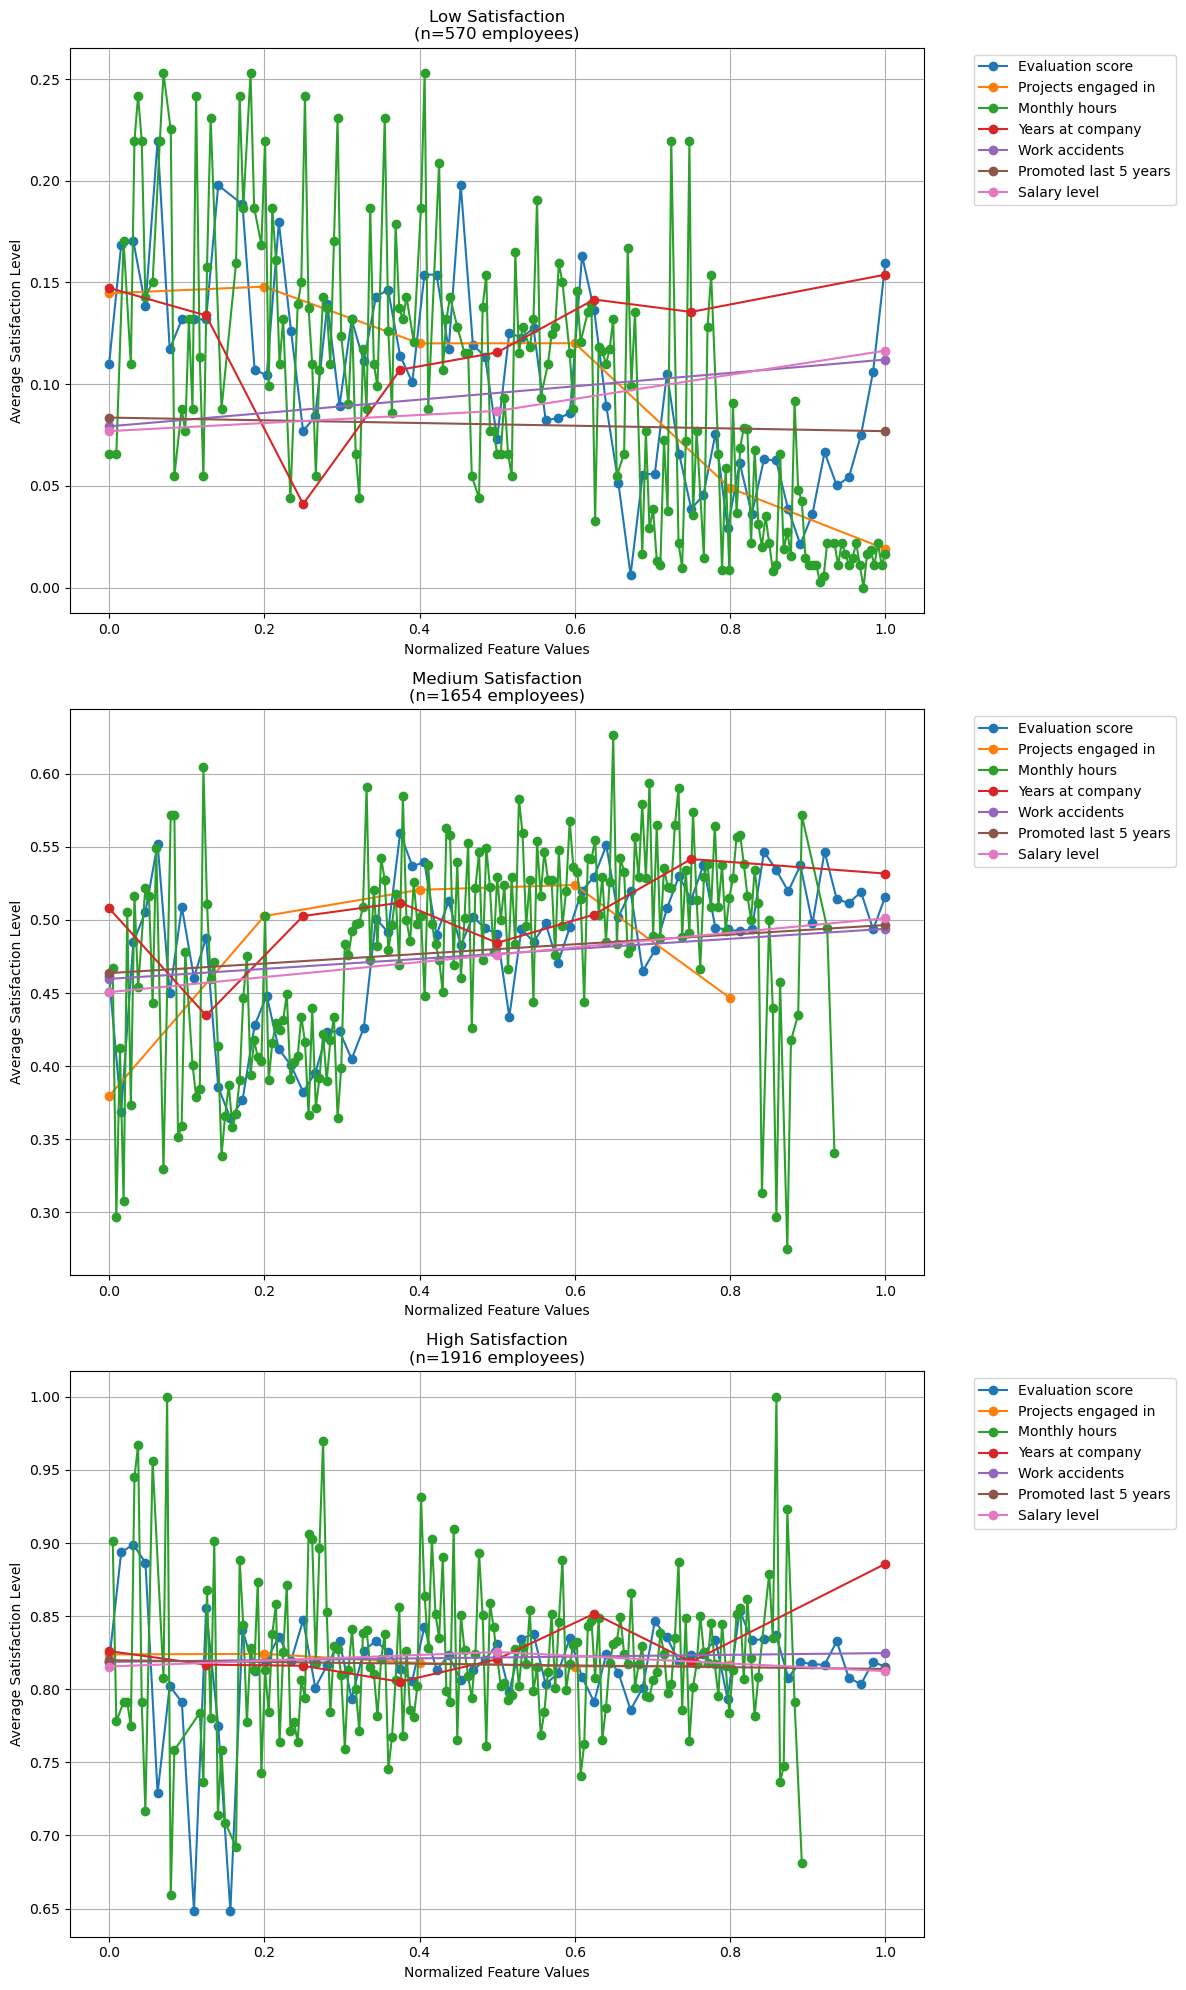


Cluster Statistics:
Low Satisfaction: 570 employees (mean satisfaction: 0.084)
Medium Satisfaction: 1654 employees (mean satisfaction: 0.464)
High Satisfaction: 1916 employees (mean satisfaction: 0.820)


In [147]:
kmeans = KMeans(n_clusters=3, random_state=42)
satisfaction_clusters = kmeans.fit_predict(data_normalized[['satisfaction level']])

data_normalized['cluster'] = satisfaction_clusters

cluster_means = data_normalized.groupby('cluster')['satisfaction level'].mean().sort_values()
cluster_mapping = {
    cluster_means.index[0]: 'Low Satisfaction',
    cluster_means.index[1]: 'Medium Satisfaction',
    cluster_means.index[2]: 'High Satisfaction'
}

plt.figure(figsize=(12, 20)) 

for i, (cluster_id, cluster_name) in enumerate(cluster_mapping.items()):
    plt.subplot(3, 1, i+1)
    
    cluster_data = data_normalized[data_normalized['cluster'] == cluster_id]
    
    for column in data_normalized.columns:
        if column not in ['satisfaction level', 'cluster']:
            average_satisfaction = cluster_data.groupby(column)['satisfaction level'].mean()
            plt.plot(average_satisfaction.index, average_satisfaction.values, 
                    marker='o', label=column.capitalize())
    
    plt.title(f"{cluster_name}\n(n={len(cluster_data)} employees)")
    plt.xlabel("Normalized Feature Values")
    plt.ylabel("Average Satisfaction Level")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("\nCluster Statistics:")
for cluster_id, cluster_name in cluster_mapping.items():
    cluster_size = len(data_normalized[data_normalized['cluster'] == cluster_id])
    cluster_mean = data_normalized[data_normalized['cluster'] == cluster_id]['satisfaction level'].mean()
    print(f"{cluster_name}: {cluster_size} employees (mean satisfaction: {cluster_mean:.3f})")


5.1 For the Least Satisfied Group:

	•	Satisfaction factors analysis:
###### This group seems to include many individuals who are naturally grumpy or dissatisfied by nature. Their satisfaction levels start to decline immediately after gaining employment and remain low for an extended period, barely improving beyond the initial level.
###### This group also appears to be less motivated or engaged. While the general analysis shows that employees are most satisfied with an optimal number of projects and working hours (neither excessive nor insufficient), individuals in this low-satisfaction group exhibit a different trend. They tend to have the highest satisfaction when working the least amount of hours and participating in only one project. However, adding even a single additional project causes their satisfaction to decline.
###### For most employees, salary is not the most critical factor influencing satisfaction. However, for this group, satisfaction is highly dependent on salary, suggesting they may prioritize financial rewards over other aspects of their job.

	•	Recommendations for the Company:
###### The company should carefully evaluate employees with persistently low satisfaction levels. These individuals may dislike working in general and could negatively impact their team’s morale. Additionally, they may use company resources inefficiently and contribute to a toxic work environment. On the other hand, employees with medium satisfaction often have legitimate reasons for their feelings and may be more open to support or intervention to improve their experience.

# Divide data into train & test

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=101)

#### Ensuring variables were splited correctly

In [36]:
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

X_train: (3312, 7)
Y_train: (3312,)
X_test: (828, 7)
Y_test: (828,)


# Building & training the basic model

In [261]:

rf_Model = RandomForestRegressor()
rf_Model.fit(X_train,Y_train)

RandomForestRegressor()

# Check accuracy

In [262]:
print(f"Train Accuracy: {rf_Model.score(X_train, Y_train):.3f}")
print(f"Test Accuracy: {rf_Model.score(X_test, Y_test):.3f}")


Train Accuracy: 0.931
Test Accuracy: 0.532


### The accuracy is very poor, let's improve it

In [214]:
# # Num of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=10)]
# # Num of features to consider in every split
# max_features = ["auto", "sqrt"]
# # Max numbers of levels in tree
# max_depth = [2, 4]
# # Min num of samples required to split the node
# min_samples_split = [2, 5]
# # Min num of samples required at each leaf node
# min_samples_leaf = [2, 5]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

In [216]:
# param_grid = {
#     "n_estimators": n_estimators,
#     "max_features": max_features,
#     "max_depth": max_depth,
#     "min_samples_split": min_samples_split,
#     "min_samples_leaf": min_samples_leaf,
#     "bootstrap": bootstrap
# }

# from sklearn.model_selection import GridSearchCV
# rf_Grid = GridSearchCV(estimator=rf_Model, param_grid= param_grid, cv = 3, verbose=2, n_jobs=4)

# rf_Grid.fit(X_train, Y_train) # Retraining the model with new params

In [211]:
# print(rf_Grid.best_params_)

{'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}


In [263]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

from sklearn.model_selection import GridSearchCV

importances = rf_Model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
print(feature_importance.sort_values('importance', ascending=False))

# After selecting important features
important_features = feature_importance[feature_importance['importance'] > 0.05]['feature'].tolist()
X = X[important_features]

# Re-split the data with updated features
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=101)

# Create and fit GridSearchCV
rf_Grid = GridSearchCV(estimator=rf_Model, param_grid=param_grid, cv=3, verbose=2, n_jobs=4)
rf_Grid.fit(X_train, Y_train)

# Get best parameters and create final model
best_params = rf_Grid.best_params_
print("Best parameters:", best_params)

# Create final model with best parameters
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, Y_train)

# Check accuracy
print(f"Train Accuracy: {final_model.score(X_train, Y_train):.3f}")
print(f"Test Accuracy: {final_model.score(X_test, Y_test):.3f}")

                 feature  importance
1         number_project    0.355941
2   average_montly_hours    0.291052
0        last_evaluation    0.204542
3     time_spend_company    0.080790
6                 salary    0.041894
4          Work_accident    0.021521
5  promotion_last_5years    0.004260
Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_fea

#### Identify most important features

In [248]:
importances = rf_Model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
print(feature_importance.sort_values('importance', ascending=False))

ValueError: All arrays must be of the same length

#### Keep only the most important features

In [186]:
important_features = feature_importance[feature_importance['importance'] > 0.05]['feature'].tolist()
X = X[important_features]

In [266]:
print(f"Train Accuracy: {rf_Grid.score(X_train, Y_train):.3f}")
print(f"Test Accuracy: {rf_Grid.score(X_test, Y_test):.3f}")

Train Accuracy: 0.930
Test Accuracy: 0.532


### Currently the accuracy is still poor, still has to be improved